In [78]:
import os, findspark

#  Spark 4.0.1
os.environ["SPARK_HOME"] = "/opt/spark-4.0.1-bin-hadoop3"
os.environ["PATH"] = os.path.join(os.environ["SPARK_HOME"], "bin") + ":" + os.environ["PATH"]


findspark.init("/opt/spark-4.0.1-bin-hadoop3")

# create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

In [79]:
# Load CSV file into Spark DataFrame

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .option("multiLine", "true")
        .option("escape", "\"")
        .csv("../data/lightcast_job_postings (for skills analysis).csv")
)

In [80]:
df.count()

72498

# **1. team-based skill dataframe**

In [88]:
import pandas as pd

skills_data = {
    "Name": ["Ivan", "Avery", "Jiayin"],
    "Python": [3, 3, 4],
    "SQL": [2, 2, 3],
    "R": [2, 2, 3],
    "Tableau": [3, 2, 3],
    "Power BI": [3, 3, 3],
    "Excel": [5, 4, 4],
    "Statistics": [3, 3, 3],
    "Data Cleaning": [2, 3, 3],
    "Communication": [4, 3, 3]
}

df_skills = pd.DataFrame(skills_data)
df_skills.set_index("Name", inplace=True)


mean_row = df_skills.mean().round(2).to_frame().T
mean_row.index = ["Team Average"]


df_with_avg = pd.concat([df_skills, mean_row])



df_with_avg


,Python,SQL,R,Tableau,Power BI,Excel,Statistics,Data Cleaning,Communication
Ivan,3.00,2.00,2.00,3.00,3.0,5.00,3.0,2.00,4.00
Avery,3.00,2.00,2.00,2.00,3.0,4.00,3.0,3.00,3.00
Jiayin,4.00,3.00,3.00,3.00,3.0,4.00,3.0,3.00,3.00
Team Average,3.33,2.33,2.33,2.67,3.0,4.33,3.0,2.67,3.33


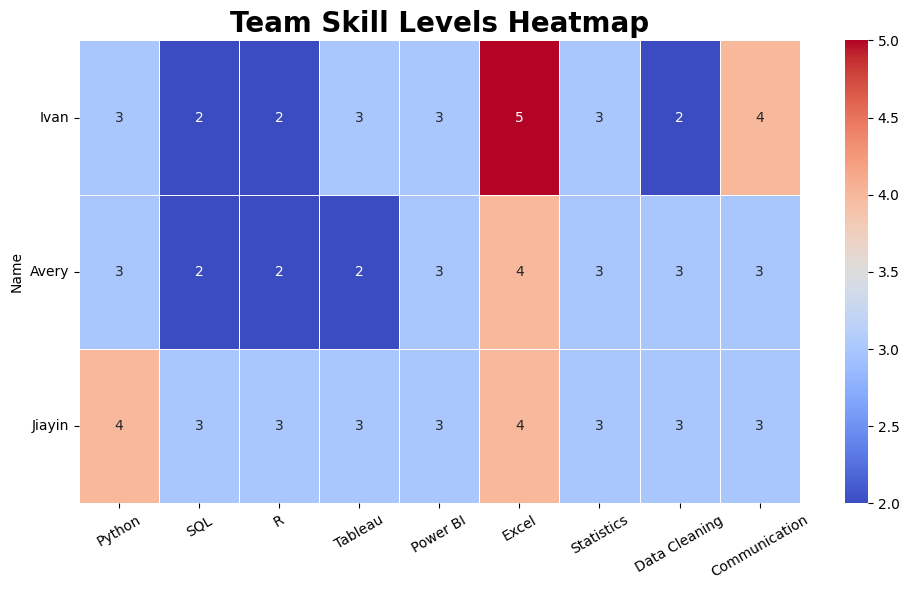

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    df_skills, 
    annot=True, 
    cmap="coolwarm", 
    linewidths=0.5,
    linecolor='white'
)

plt.title("Team Skill Levels Heatmap", fontsize=20, fontweight='bold')
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### **Ivan**

* Technical skills range from basic to intermediate, with Python, SQL, and R at an introductory level.
* Strong proficiency in Excel, with solid capability in data organization and presentation.
* Communication stands out as the key strength, suitable for tasks involving cross-team collaboration and result delivery.

---

### **Avery**

* Balanced skill profile with steady performance in core data-processing abilities such as Python, SQL, R, and Data Cleaning.
* Confident in Excel for routine analysis and reporting tasks.
* A well-rounded analyst with stable foundational skills across all areas.

---

### **Jiayin**

* Stronger technical orientation, especially with higher proficiency in Python and Excel.
* Maintains consistent intermediate-level ability across SQL, R, visualization tools, and data cleaning.
* A comprehensive technical profile, suitable for more automation-, modeling-, or technically focused analytical tasks.

# **2. Compare team skills to industry requirements**

## **2.1 Extract most in-demand skills from IT job postings.**

We selected **SOFTWARE_SKILLS_NAME** and **SPECIALIZED_SKILLS_NAME** as the sources for extracting skills because:

* These two fields focus on the core technical skills required in IT and data-related roles.
* **SOFTWARE_SKILLS_NAME** includes essential tools and software skills such as Python, SQL, Tableau, and AWS.
* **SPECIALIZED_SKILLS_NAME** provides additional domain-specific technical skills, including Machine Learning, Data Modeling, and Forecasting.
* Compared with other skill fields (e.g., *COMMON_SKILLS_NAME*), these two are more technical and therefore more suitable for identifying the most in-demand skills in the job market.



In [84]:
from pyspark.sql.functions import col, concat_ws

df_preview = df.select(
    "SOFTWARE_SKILLS_NAME",
    "SPECIALIZED_SKILLS_NAME"
).withColumn(
    "merged_skills",
    concat_ws(", ", col("SOFTWARE_SKILLS_NAME"), col("SPECIALIZED_SKILLS_NAME"))
)

df_preview = df_preview.select("merged_skills")
df_preview.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [85]:
from pyspark.sql.functions import regexp_replace, trim, split, explode, col


df_clean = df_preview.withColumn(
    "merged_clean",
    regexp_replace("merged_skills", r"[\[\]\n\"]", "")
)


df_clean = df_clean.withColumn(
    "skill_array",
    split(col("merged_clean"), ",")
)


df_clean = df_clean.withColumn(
    "skill_array",
    split(trim(col("merged_clean")), ",\s*")
)


df_exploded = df_clean.select(
    explode("skill_array").alias("skill")
)


df_exploded = df_exploded.filter(trim(col("skill")) != "")

df_exploded.show(20, truncate=False)

+----------------------------------------+
|skill                                   |
+----------------------------------------+
|SQL (Programming Language)              |
|Power BI                                |
|Merchandising                           |
|Predictive Modeling                     |
|Data Modeling                           |
|Advanced Analytics                      |
|Data Extraction                         |
|Statistical Analysis                    |
|Data Mining                             |
|Business Analysis                       |
|Finance                                 |
|Algorithms                              |
|Statistics                              |
|SQL (Programming Language)              |
|Ad Hoc Reporting                        |
|Power BI                                |
|Economics                               |
|Oracle Business Intelligence (BI) / OBIA|
|Oracle E-Business Suite                 |
|PL/SQL                                  |
+----------

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1774/3409365684.py:18: SyntaxWarning: invalid escape sequence '\s'
  split(trim(col("merged_clean")), ",\s*")


In [86]:
from pyspark.sql.functions import col

top_skills = (
    df_exploded
    .groupBy("skill")
    .count()
    .orderBy(col("count").desc())
)

top_skills.show(20, truncate=False)

+----------------------------------------+-----+
|skill                                   |count|
+----------------------------------------+-----+
|SQL (Programming Language)              |43466|
|Data Analysis                           |28515|
|Python (Programming Language)           |24506|
|SAP Applications                        |24246|
|Dashboard                               |23712|
|Tableau (Business Intelligence Software)|23562|
|Power BI                                |21700|
|Computer Science                        |17287|
|Project Management                      |13711|
|Business Process                        |13278|
|Business Requirements                   |13035|
|Microsoft Excel                         |12826|
|Finance                                 |12438|
|R (Programming Language)                |12208|
|Business Intelligence                   |10423|
|Microsoft Azure                         |9518 |
|Amazon Web Services                     |9384 |
|Agile Methodology  

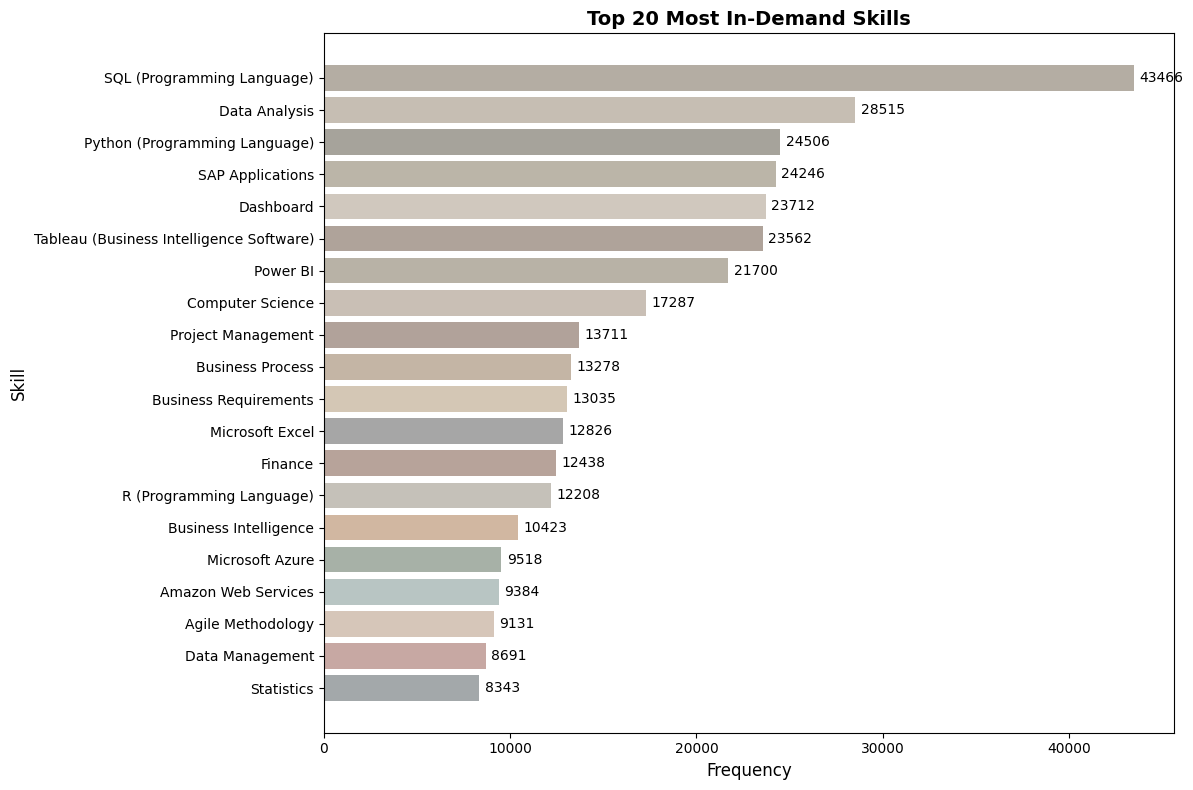

In [87]:
import matplotlib.pyplot as plt
import numpy as np


top20_pdf = top_skills.limit(20).toPandas()


top20_pdf = top20_pdf.sort_values("count", ascending=True)


morandi_colors = [
    "#A3A8AA", "#C7A8A3", "#D6C6B9", "#B8C5C3", "#A7B1A7",
    "#D1B7A1", "#C5C1B9", "#B7A39A", "#A6A6A6", "#D4C7B5",
    "#C4B5A5", "#B1A29A", "#C9BFB5", "#B8B2A6", "#AFA39A",
    "#D0C8BE", "#BBB5A8", "#A6A39B", "#C6BEB3", "#B4ADA3"
]


plt.figure(figsize=(12, 8))
bars = plt.barh(top20_pdf['skill'], top20_pdf['count'], color=morandi_colors)


for bar in bars:
    width = bar.get_width()
    plt.text(width + 300,           
             bar.get_y() + bar.get_height()/2,
             f"{int(width)}",
             va='center', fontsize=10)


plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Skill", fontsize=12)
plt.title("Top 20 Most In-Demand Skills", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## **2.2 Identify gaps between team skill levels and job expectations**


Based on the team’s average skill scores and the market’s Top 20 most in-demand skills, the following gaps between team capabilities and job expectations are identified:

---

### **1. Programming & Database Skills (Python / SQL)**

- SQL ranks **#1 (43,466 postings)** and Python ranks **#3 (24,506 postings)**, making them essential for nearly all data roles.  
- Team averages:  
  - **Python: 3.33 / 5** (moderate, slightly below market expectations)  
  - **SQL: 2.33 / 5** (low, below typical hiring standards)  

**Gap:** SQL requires significant improvement; Python also needs enhancement.

---

### **2. Statistics and Data Management Skills Are Insufficient**

- Statistics and Data Management both appear in the Top 20 most in-demand skills.  
- Team averages:  
  - **Statistics: 3.00 / 5**  
  - **Data Cleaning: 2.67 / 5**  

**Gap:** Both statistical foundations and data-cleaning capabilities fall short of market expectations.

---

### **3. BI Tools (Tableau / Power BI) Fall Short of Market Demand**

- Tableau (23,562 postings) and Power BI (21,700 postings) are within the top 10 in-demand skills.  
- Team averages:  
  - **Tableau: 2.67 / 5**  
  - **Power BI: 3.00 / 5**  

**Gap:** Visualization tool proficiency is below the level expected for analyst roles.

---

### **4. Missing Business Analysis & Process Skills**

Highly demanded skills include:

- Business Requirements (13,035 postings)  
- Business Process (13,278 postings)  
- Project Management (13,711 postings)

These skill categories **do not appear in the team’s assessment**, indicating potential blind spots.

**Gap:** Business analysis, requirement documentation, and process mapping skills are missing.

---

### **5. Excel Meets Expectations but Advanced Skills May Lag**

- Excel is a commonly required skill (12,826 postings).  
- Team average: **4.33 / 5**, a strong performance.

**Gap:** Minimal, though advanced Excel modeling may still require improvement.

---

### **6. Communication Is a Strength but Still Needs Alignment with Market Expectations**

- Team average: **3.33 / 5**, showing a stable competency.

**Gap:** Cross-functional communication and business storytelling can be further strengthened.